# Besian Neural Network

In [2]:
import pandas as pd  
import torch  
import torch.nn as nn  
import torch.nn.functional as F  
import torch.optim as optim  
from torch.utils.data import Dataset, DataLoader  
import numpy as np

# 1. 数据准备  
class MyDataset(Dataset):  
    def __init__(self, X, y):  
        self.X = X  
        self.y = y  

    def __len__(self):  
        return len(self.y)  

    def __getitem__(self, idx):  
        return self.X[idx], self.y[idx]  

In [3]:
# 假设你的数据以制表符分隔并保存在 'data.txt' 中  
data_path = "results_feature_error.txt"
with open(data_path, 'r') as f:
    lines = f.readlines()[1:]

X = []
y = []
stdList = []
for line in lines:
    line = line.strip().split()
    px = float(line[2])
    py = float(line[3])
    intensity = float(line[5])
    X.append([px, py, intensity])
    y.append([float(x) for x in line[0:2]])
    stdList.append(float(line[6]))

# 转为 PyTorch tensors  
X_tensor = torch.FloatTensor(X)  
y_tensor = torch.FloatTensor(y)

# 创建数据加载器  
dataset = MyDataset(X_tensor, y_tensor)  
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)  

# 2. 定义贝叶斯神经网络  
class BayesianNN(nn.Module):  
    def __init__(self):  
        super(BayesianNN, self).__init__()  
        self.fc1 = nn.Linear(X_tensor.shape[1], 64)  
        self.dropout = nn.Dropout(0.5)  # 设置Dropout比例
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.fc4 = nn.Linear(64, 64)
        self.fc5 = nn.Linear(64, 64)

        self.predict = nn.Linear(64, y_tensor.shape[1])
        self.get_log_var = nn.Linear(64, y_tensor.shape[1])

    def forward(self, x):  
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        x = self.dropout(x)

        predict = self.predict(x)
        log_var = self.get_log_var(x)
        
        return predict, log_var

# 3. 定义损失函数
def loss_fn(y, y_pred, log_var):
    return torch.sum(0.5 * torch.exp(-log_var) * (y - y_pred) ** 2 + 0.5 * log_var)

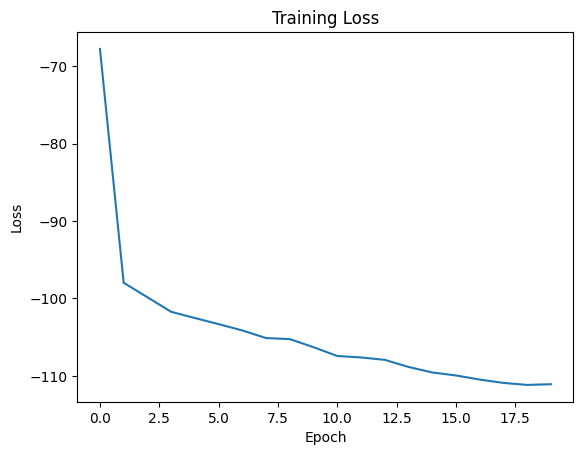

Epoch [20/20], Loss: -111.0820


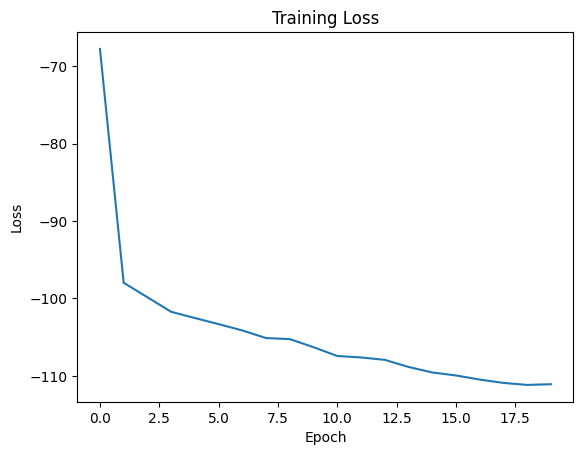

In [4]:
from IPython.display import clear_output, display
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# 3. 训练模型  
model = BayesianNN()  
criterion = loss_fn
optimizer = optim.Adam(model.parameters(), lr=0.001)  

num_epochs = 20

losses = []

plt.ion()
fig, ax = plt.subplots()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(targets, outputs[0], outputs[1])
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    
    epoch_loss /= len(dataloader)
    losses.append(epoch_loss)
    
    clear_output(wait=True)
    ax.clear()
    ax.plot(losses)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.set_title('Training Loss')
    display(fig)
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {epoch_loss:.4f}')


In [5]:
# 4. 使用 MC Dropout 进行预测  
def predict_with_uncertainty(model, x, n_iter=100, dimy=2):  
    model.train()  # 确保模型处于训练模式以启用Dropout  
    predictions = []
    log_var = []
    
    for i in range(n_iter):  
        with torch.no_grad():  
            mean_pred, log_var_pred = model(x)
            predictions.append(mean_pred.cpu().numpy())
            log_var.append(log_var_pred.cpu().numpy())
    
    predictions = np.array(predictions)
    log_var = np.array(log_var)
    pred_mean = np.mean(predictions, axis=0) 
    uncertainty_epistemic = np.sqrt(np.var(predictions, axis=0))
    uncertainty_aleatoric = np.sqrt(np.mean(np.exp(log_var), axis=0))
    return pred_mean, uncertainty_epistemic, uncertainty_aleatoric

# 进行预测
y_pred = []
y_uncertainty = []
for i in range(len(X_tensor)):
    model.eval()  
    mean_y, u_e, u_a = predict_with_uncertainty(model, X_tensor[i].view(1, -1), dimy=1)
    y_pred.append(mean_y)
    y_uncertainty.append(np.sqrt(u_e ** 2 + u_a ** 2))
    if i % 100 == 0:
        print(f'Prediction {i}/{len(X_tensor)}')


Prediction 0/21025
Prediction 100/21025
Prediction 200/21025
Prediction 300/21025
Prediction 400/21025
Prediction 500/21025
Prediction 600/21025
Prediction 700/21025
Prediction 800/21025
Prediction 900/21025
Prediction 1000/21025
Prediction 1100/21025
Prediction 1200/21025
Prediction 1300/21025
Prediction 1400/21025
Prediction 1500/21025
Prediction 1600/21025
Prediction 1700/21025
Prediction 1800/21025
Prediction 1900/21025
Prediction 2000/21025
Prediction 2100/21025
Prediction 2200/21025
Prediction 2300/21025
Prediction 2400/21025
Prediction 2500/21025
Prediction 2600/21025
Prediction 2700/21025
Prediction 2800/21025
Prediction 2900/21025
Prediction 3000/21025
Prediction 3100/21025
Prediction 3200/21025
Prediction 3300/21025
Prediction 3400/21025
Prediction 3500/21025
Prediction 3600/21025
Prediction 3700/21025
Prediction 3800/21025
Prediction 3900/21025
Prediction 4000/21025
Prediction 4100/21025
Prediction 4200/21025
Prediction 4300/21025
Prediction 4400/21025
Prediction 4500/21025


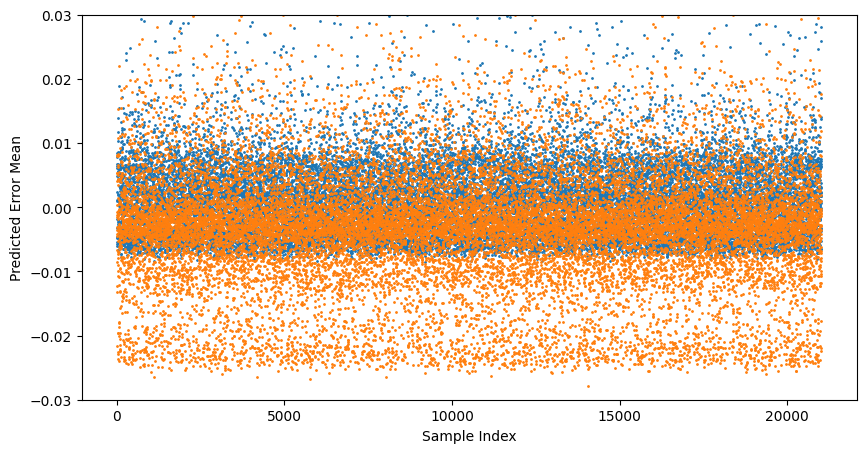

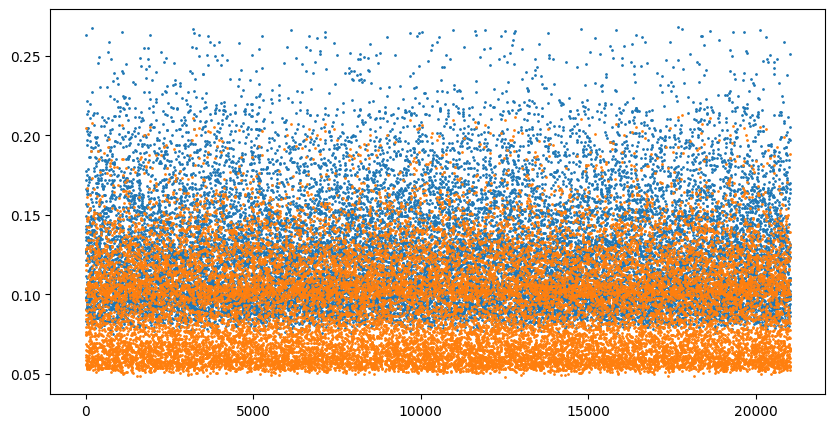

In [10]:
y_pred = np.array(y_pred).reshape(-1, 2)
y_uncertainty = np.array(y_uncertainty).reshape(-1, 2)

plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_pred)), y_pred[:, 0]-0.05, label='Predicted px', s=1)
plt.scatter(range(len(y_pred)), y_pred[:, 1]-0.03, label='Predicted py', s=1)
plt.ylim(-0.03, 0.03)
plt.xlabel('Sample Index')
plt.ylabel('Predicted Error Mean')

plt.figure(figsize=(10, 5))
plt.scatter(range(len(y_uncertainty)), y_uncertainty[:, 0], label='Uncertainty px', s=1)
plt.scatter(range(len(y_uncertainty)), y_uncertainty[:, 1], label='Uncertainty py', s=1)

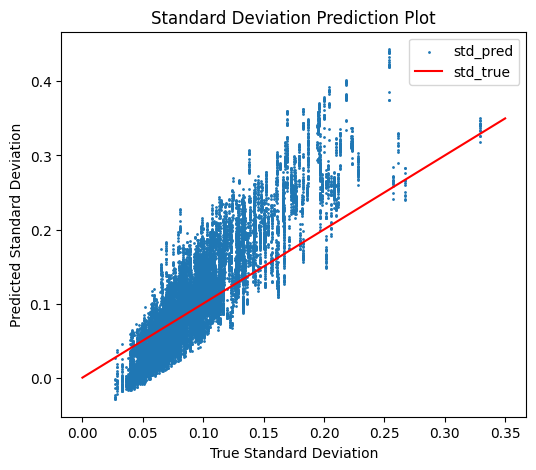

In [25]:
y_uncertainty_norm = [np.linalg.norm(y_uncertainty[i]) for i in range(len(y_uncertainty))]
y_uncertainty_norm = np.array(y_uncertainty_norm)

for i in range(len(y_uncertainty_norm)):
    y_uncertainty_norm[i] = y_uncertainty_norm[i] - 0.15 + stdList[i]

plt.figure(figsize=(6, 5))
plt.scatter(stdList, y_uncertainty_norm, s=1, label='std_pred')
plt.plot([0, 0.35], [0, 0.35], color='red', label='std_true')
plt.ylabel('Predicted Standard Deviation')
plt.xlabel('True Standard Deviation')
plt.title('Standard Deviation Prediction Plot')
plt.legend()
plt.show()